In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# train_data_path = join('../input', 'train.csv')
# sub_data_path = join('../input', 'test.csv')

In [4]:
data_dir =os.getenv("HOME") +"/aiffel/kaggle_kakr_housing/data/" # [[YOUR CODE]]
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [5]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [6]:
y = data['price']

del data['price']

In [7]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [8]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

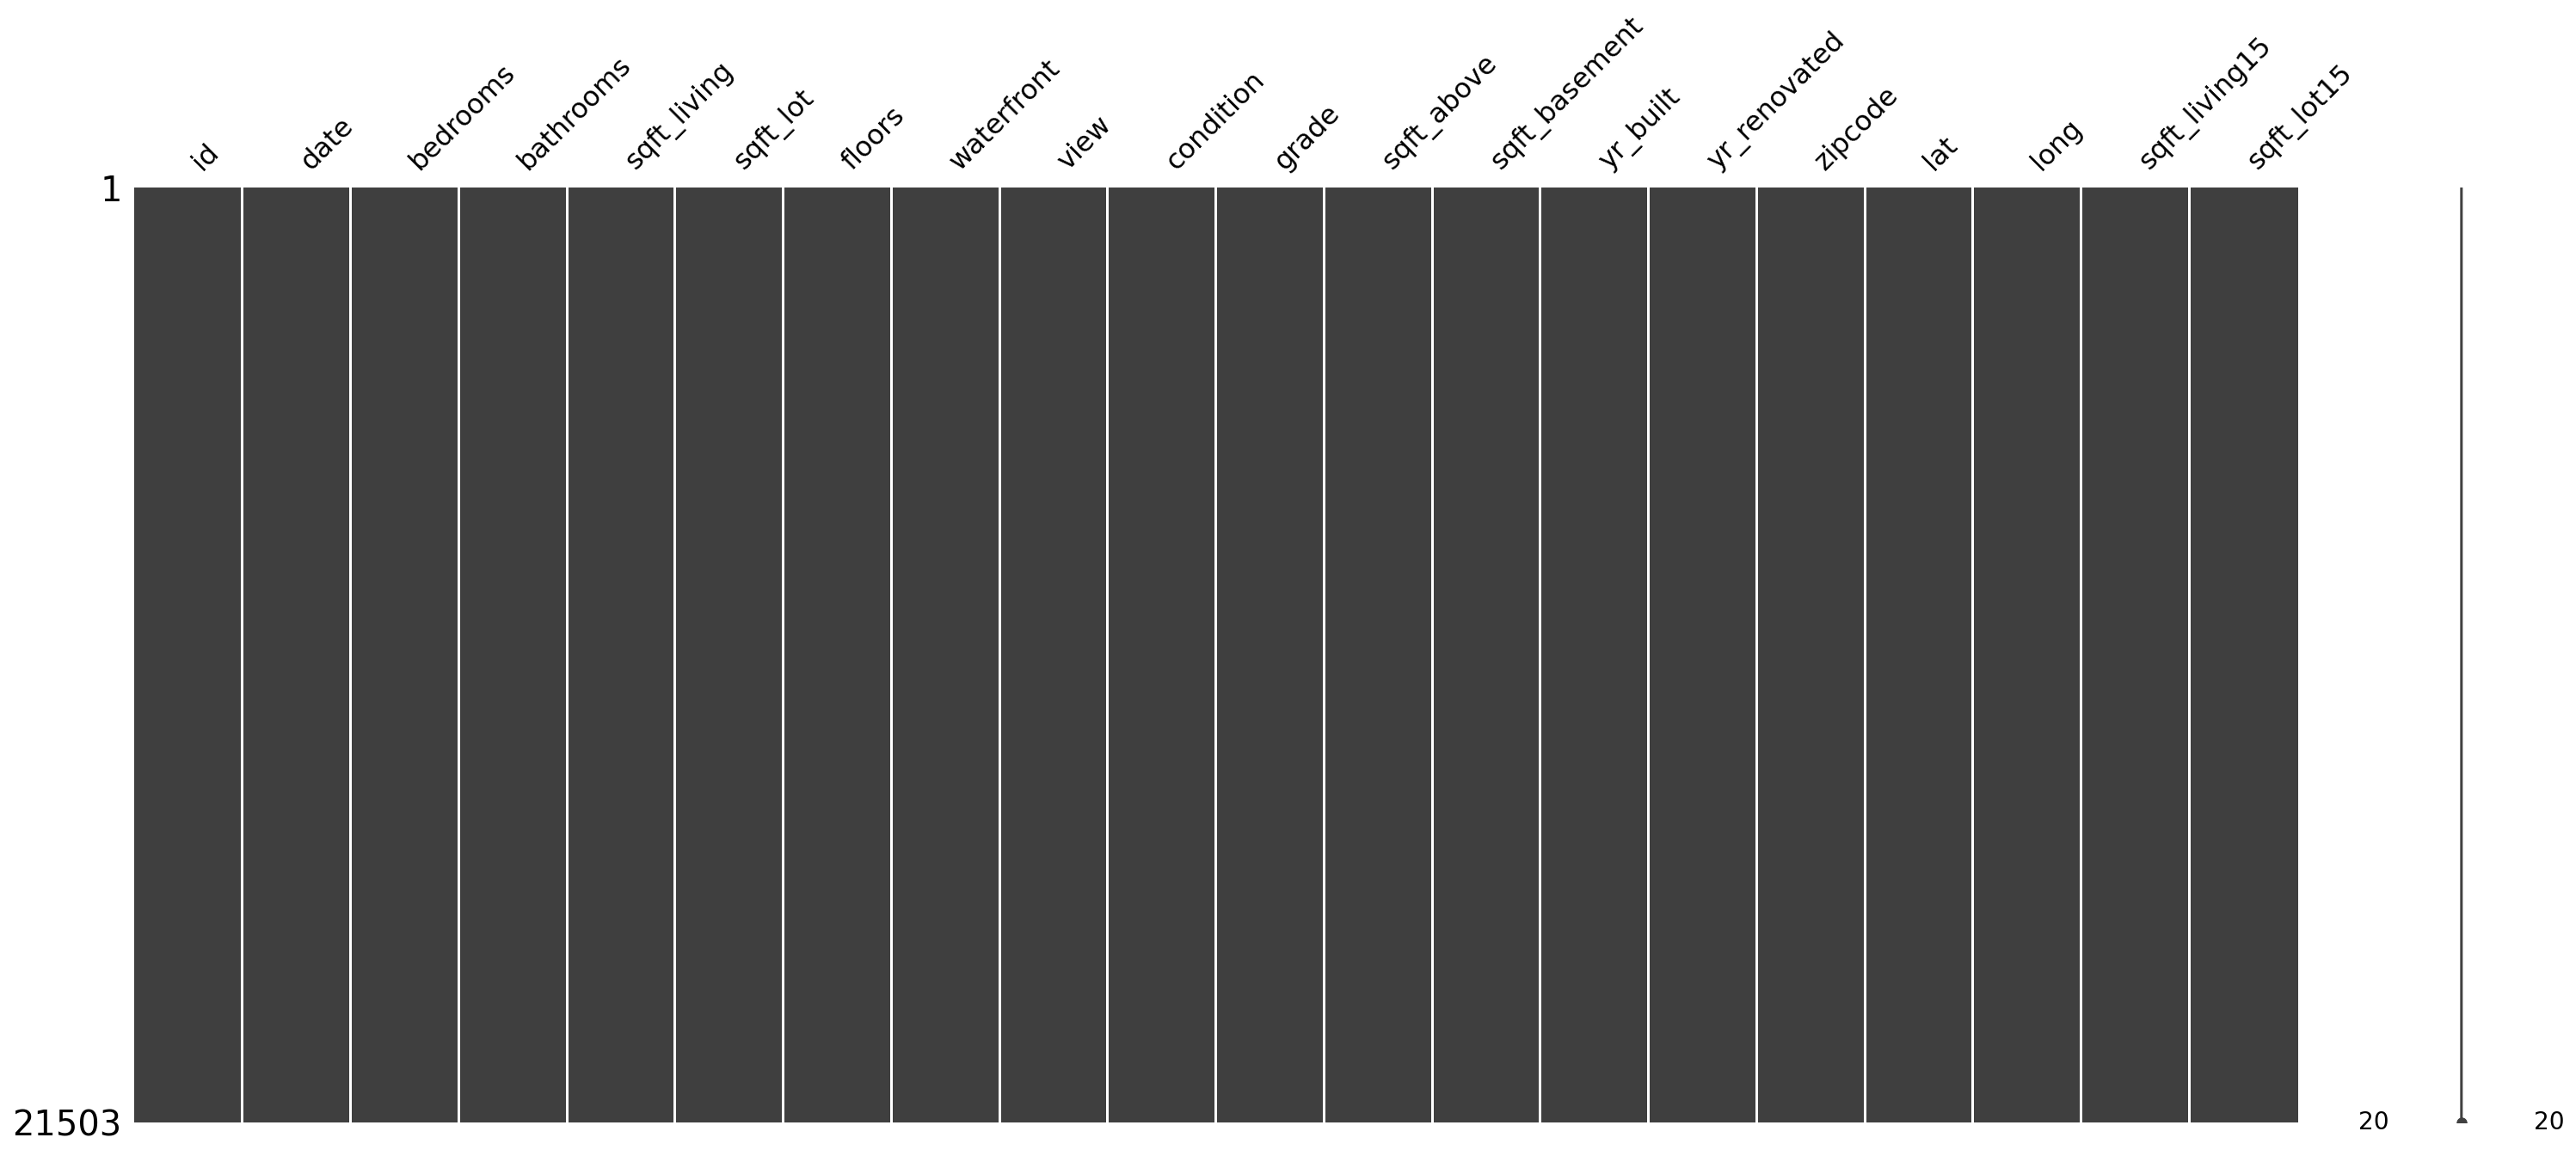

In [9]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

위에 출력된 것은 data라는 DataFrame을 매트릭스 모양 그대로 시각화한 것입니다. 만약 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나옵니다. 결측치가 없다면 매트릭스 전체가 까맣게 나올 겁니다. 실제로 그렇게 나왔나요??

아래와 같이 직접 결측치의 개수를 출력해서 확인할 수도 있습니다.

- 데이터프레임 고급 인덱싱
https://datascienceschool.net/01%20python/04.03%20%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1.html?highlight=%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%94%84%EB%A0%88%EC%9E%84%20%EA%B3%A0%EA%B8%89%20%EC%9D%B8%EB%8D%B1%EC%8B%B1

우선 id를 가지고 데이터프레임 인덱싱을 적용해 사용법을 익혀봅시다.

천천히 진행하면 3단계를 거칩니다.

1. id컬럼이 결측치인지 확인합니다.
2. 결측치인 데이터만 뽑아냅니다.
3. 결측치인 데이터의 개수를 셉니다.  

코드를 하나하나 작성해 볼까요?

In [10]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


무엇이 출력되나요?! True와 False로 이루어진 데이터프레임이 출력된다는 점에 주목하세요!

이 다음에 이루어지는 것이 인덱싱입니다. 데이터프레임을 이용해서 데이터프레임으로부터 원하는 값을 가져오는 아주 훌륭한 기능입니다!

In [11]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

어떤가요? 결측치가 없기 때문에 빈 데이터프레임이 나왔네요.

인덱싱을 이용하면 데이터프레임을 그대로 사용할 수 있다는 것이 매우 큰 장점이에요. 인덱싱 기능이 없었더라면 항상 데이터프레임을 배열로 바꾸고 for문을 사용해야 했을겁니다. 게다가 인덱싱 기능이 속도면에서도 월등히 빠릅니다.

이제 마지막으로 데이터 개수를 출력해주면 결측치 개수를 확인할 수 있네요.

In [12]:
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')

id: 0


In [13]:
# 한 번에 뿅!
# 추가 : 위에 실행했던 코드는 f-string으로 작동하지만 해당 코드는 대괄호가 2개가 있어 f-string으로 표현하면 에러가 발생합니다. 이럴 경우 format으로 실행합니다.
# 추가에 대한 내용 : https://blockdmask.tistory.com/429
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


id 컬럼 외에도 모든 컬럼에 적용해야 하니 for문을 사용하면 완성입니다!

In [14]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

필요 없는 id 컬럼을 제거합니다. 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장해두고 지우도록 하겠습니다.

In [15]:
sub_id = data['id'][train_len:]
del data['id']
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date 컬럼은 apply 함수로 필요한 부분만 잘라줍니다.

Pandas Lambda, apply를 활용하여 복잡한 로직 적용하기
- https://data-newbie.tistory.com/207

In [16]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

✓ 각 변수들의 분포 확인  

전체 데이터들의 분포를 확인합니다.  

특히 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업을 합니다.

아래 시각화 코드를 통해 id 컬럼을 제외한 19개 컬럼에 대해 한 번에 모든 그래프를 그려줍니다.  

10행 2열의 subplot에 그래프를 그리기 위해 2중 for문을 사용하고 있군요.

그래프의 종류는 sns.kdeplot을 사용합니다.  

kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수입니다.

- seaborn.kdeplot https://seaborn.pydata.org/generated/seaborn.kdeplot.html

우리도 아래 코드로 전체 그래프를 그려보죠. 코드 실행 완료 후에도 실제 그래프가 나타나기까지 몇 초 정도 소요될 수 있습니다.

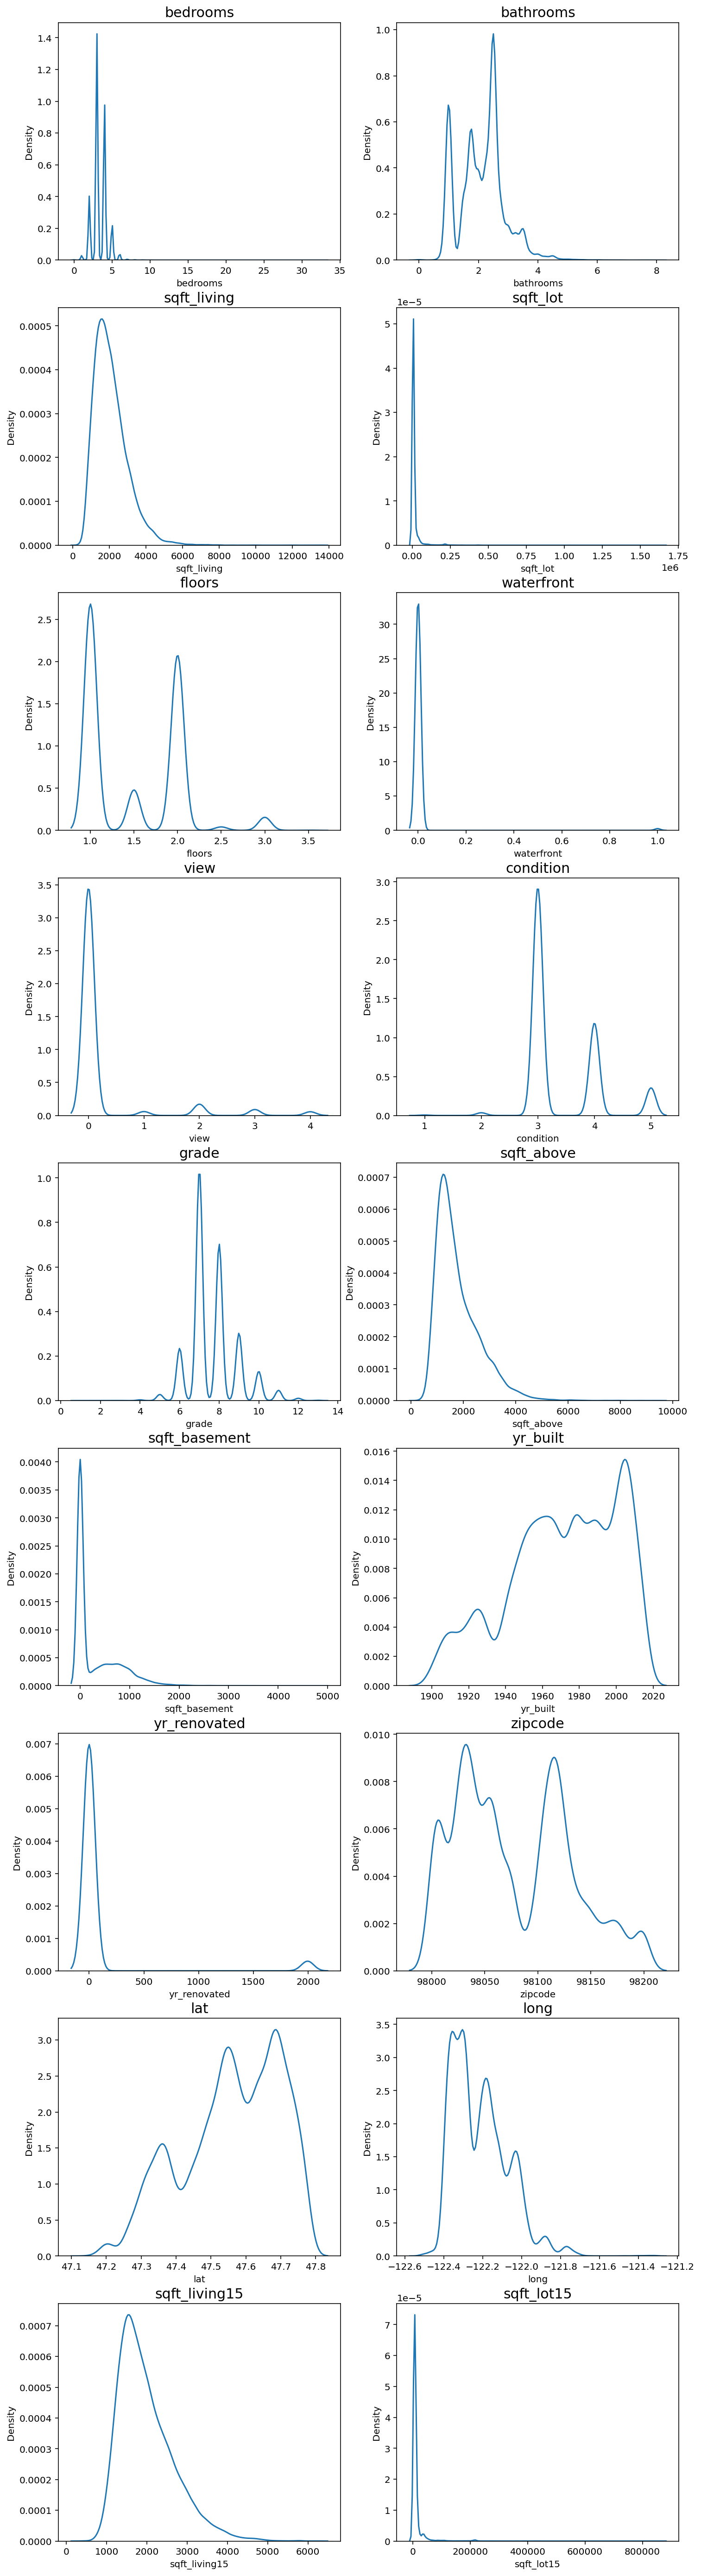

In [17]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [18]:
# fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# # id 변수는 제외하고 분포를 확인합니다.
# count = 0
# columns = data.columns
# for row in range(10):
#     for col in range(2):
#         sns.kdeplot(data[columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(columns[count], fontsize=15)
#         count+=1
#         if count == 19 :
#             break

그래프의 분포를 보면 어떤 처리를 해주면 좋을지 떠올릴 수 있습니다.

위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보이는군요.

이렇게 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다. 자세한 이유는 아래에서 다시 다루고, 우선 결과부터 살펴봅시다.

아래와 같이 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환을 해주도록 하겠습니다. numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수입니다.






price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [19]:
# skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

# for c in skew_columns:
#     data[c] = np.log1p(data[c].values)

In [20]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

얍💢


In [22]:
# fig, ax = plt.subplots(3, 2, figsize=(10, 15))

# count = 0
# for row in range(3):
#     for col in range(2):
#         if count == 5:
#             break
#         sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(skew_columns[count], fontsize=15)
#         count+=1

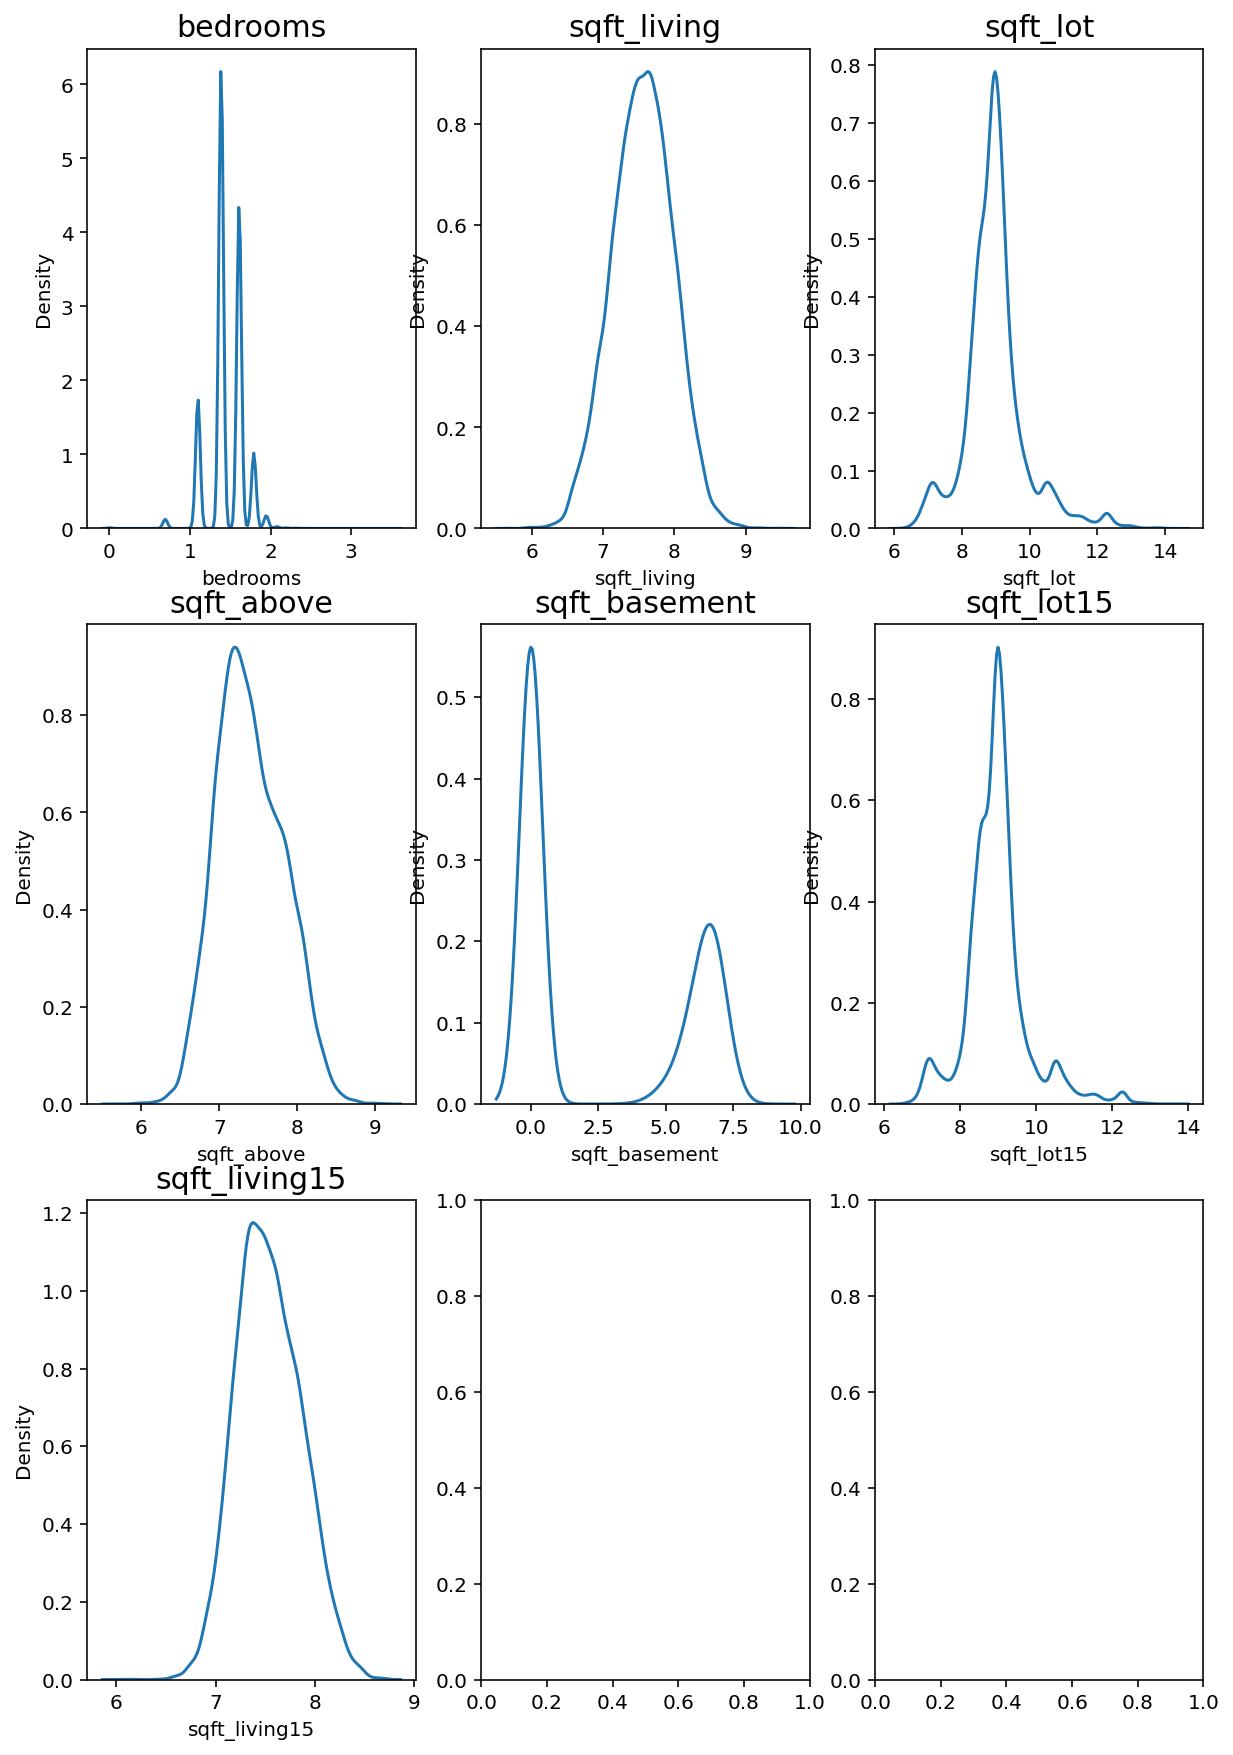

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(10, 15))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(3):
    for col in range(3):
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == len(skew_columns) :
            break

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

이전보다 훨씬 치우침이 줄어든 분포를 확인할 수 있습니다.

그렇다면 왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까요?
이는 로그 함수의 형태를 보면 알 수 있습니다. 아래의 일반적인 로그 함수를 살펴봅시다.

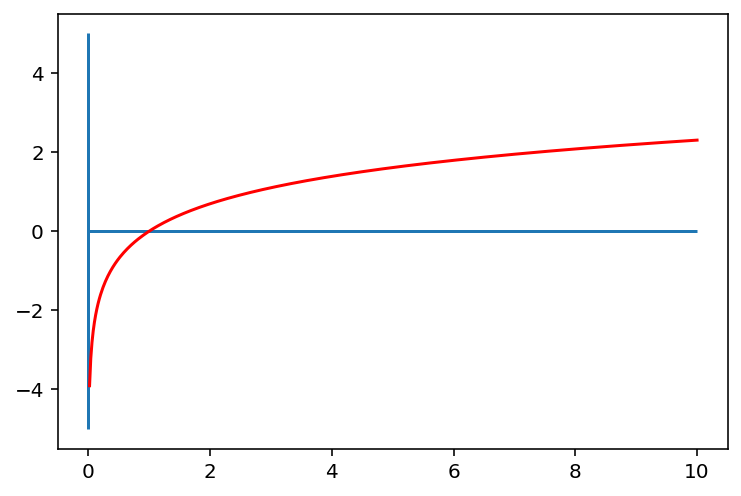

In [24]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

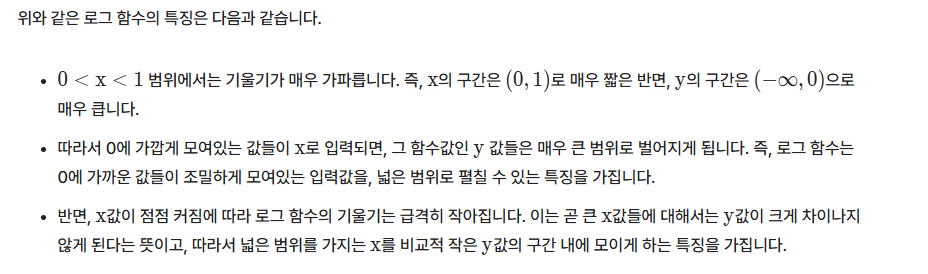

위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있는 것이죠.

왜 한쪽으로 치우친 분포를 로그 변환을 취하게 되면 정규분포 모양으로 고르게 분포하게 될 수 있는지 이해가 되시나요?

그렇다면 우리가 맞추어야 할 타겟인 집의 가격, 즉 data[price]의 분포를 로그 변환했을 때 결과를 유추해봅시다.
원래 price의 분포는 다음과 같습니다.

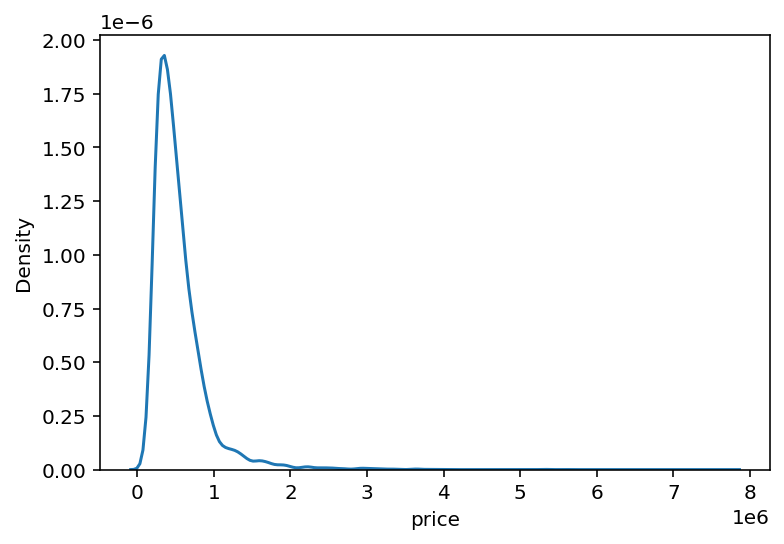

In [25]:
sns.kdeplot(y)
plt.show()

Q3. 위 분포를 log 변환하게 되면 그 분포는 어떤 모양을 가지게 될까요?  

위 분포는 0 쪽으로 매우 심하게 치우쳐져 있는 분포를 보인다.  

즉, 0과 1000000 사이에 대부분의 값들이 몰려있고, 아주 소수의 집들이 굉장히 높은 가격을 보인다.  

따라서 이 분포에 로그 변환을 취하면, 0에 가깝게 몰려있는 데이터들은 넓게 퍼질 것이고, 매우 크게 퍼져있는 소수의 데이터들은 작은 y값으로 모일 것이다.  

즉, 왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지고 오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모이게 되므로 전체 분포는 정규분포의 형상을 띄는 방향으로 변환될 것이다.

직접 확인해봅시다!

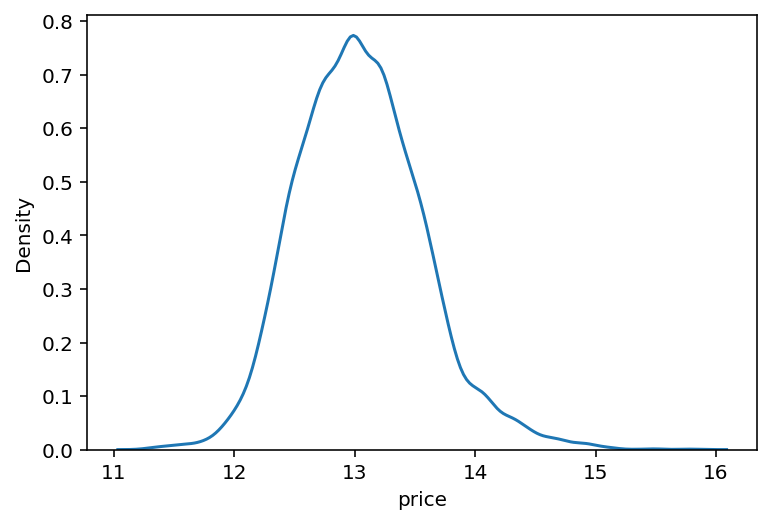

In [26]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

확실히 아름다운 정규분포의 모양으로 가까워진 것으로 보입니다!

그러면 여기까지 로그 변환이 필요한 데이터에 대해 처리를 마무리하였으니, 아래와 같이 전체 데이터를 다시 나누어 줍니다.

위에서 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 즉 x에 저장하고, train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장합니다.

In [27]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

In [28]:
print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


✓ 모델링
---
이제 본격적으로 학습시킬 모델을 준비합니다.  
Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용합니다.  

블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법입니다.  

블렌딩은 앙상블 기법이라고 하기도 하는데요, 자세한 내용을 다음 포스팅에서 살짝 읽어보겠습니다.  

Part 1. Introduction to Ensemble Learning
- https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.

Q. 앙상블이란 무엇이고, 어떤 아이디어로부터 착안된 기법인가요?

앙상블(Ensemble)이란 여러 개의 학습 알고리즘을 결합하여 더 정확한 예측을 만들어내는 기법입니다. 이 아이디어는 하나의 강력한 모델을 사용하는 것보다 여러 개의 약한 모델을 결합하여 더 나은 성능을 얻을 수 있다는 점에서 착안되었습니다. 이를 통해 단일 모델의 한계를 극복하고, 예측 성능을 향상시키는 것이 앙상블 기법의 목표입니다.

Q. 앙상블 기법 중 가장 기본적인 것은 보팅(Voting)과 에버리징(Averaging)입니다. 각각은 무엇이고, 언제 쓰이나요?  

Voting은 여러 모델이 분류해 낸 결과들로부터 말 그대로 다수결 투표를 통해 최종 결과를 선택하는 방법으로, 분류 문제에서 사용됩니다.  
반면, Averaging은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용됩니다.

네, 앙상블은 강력한 개별 모델 하나보다 약한 여러 개의 모델의 결과를 합치는 것이 낫다는 기본 전제로부터 시작됩니다.  

하지만 위 전제가 실제로 성립한다면, 그 이유는 무엇일까요?  

이에 관한 내용은 아래 포스팅에서 읽어보겠습니다. 중간에 0과 1로 나타낸 예시가 굉장히 직관적이니 유심히 읽어보고, 다음 퀴즈를 풀어보세요!

Model Ensembling(모델 앙상블) Guide

https://modulabs.co.kr/blog/model-ensembling-guide/

Q. 각각 성능이 70%(0.7)인 다섯 개의 분류기가 있다고 가정합니다.
이 때 이 다섯 개의 모델이 예측한 결과에 다수결 투표를 진행하여 최종 결과를 결정한다면 예상 정확도는 얼마일까요?
(힌트: 고등학생 때 배웠던 순열과 조합의 독립시행의 확률을 떠올려보세요!)

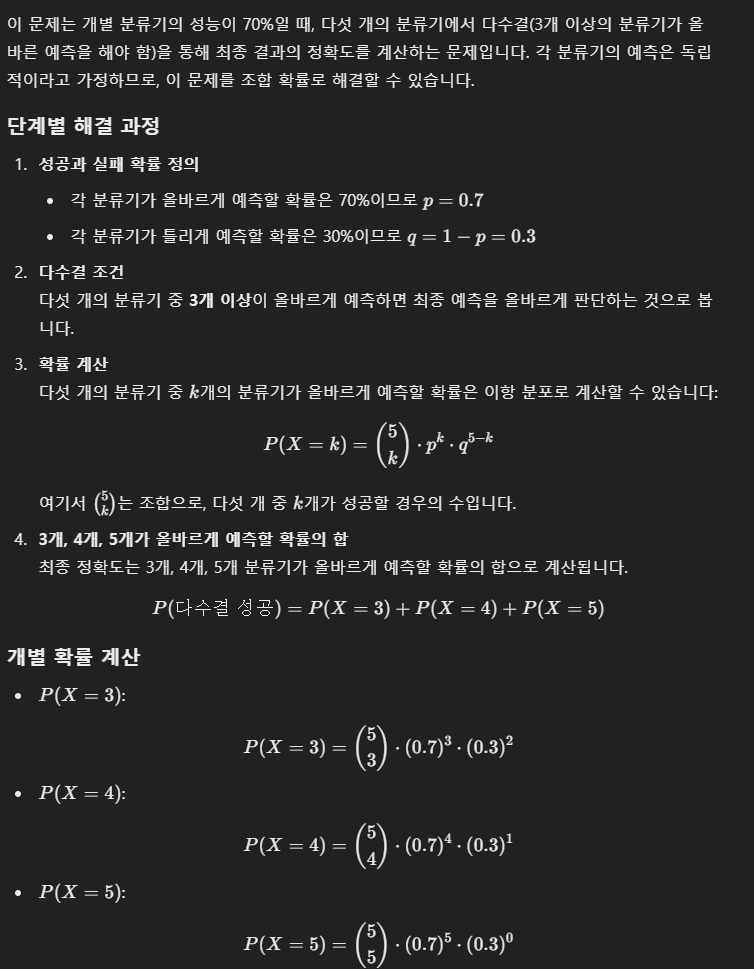

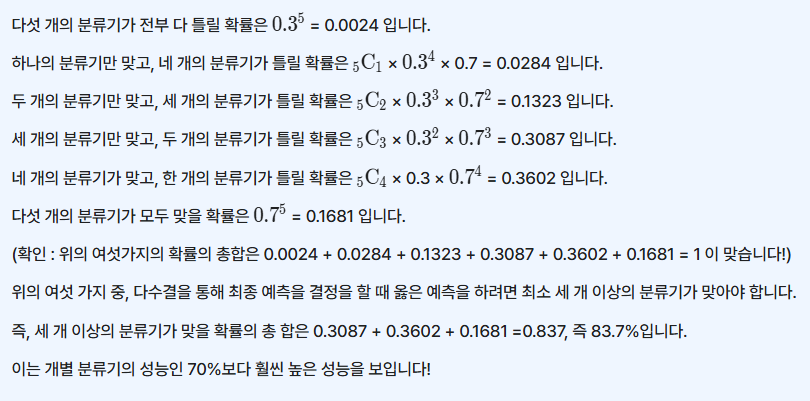

In [29]:
from math import comb

# 개별 확률
p = 0.7
q = 1 - p

# 확률 계산
P_X_3 = comb(5, 3) * (p ** 3) * (q ** 2)
P_X_4 = comb(5, 4) * (p ** 4) * (q ** 1)
P_X_5 = comb(5, 5) * (p ** 5) * (q ** 0)

# 최종 다수결 성공 확률
P_majority_success = P_X_3 + P_X_4 + P_X_5
P_majority_success

0.8369199999999999

간단한 산술을 통해, 어느 정도의 성능을 보이는 개별 모델의 결과를 종합하면 보다 나은 결과를 만들어낼 수 있다는 것을 확인할 수 있군요.

우리는 이번에 회귀 문제를 풀고 있으므로, 위 분류기의 앙상블처럼 투표로 정하는 대신 예측 결과를 평균 내어 활용할 예정입니다.

✓ Average Blending
여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들겠습니다.

모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용합니다.

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [30]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [ ]:
# def get_cv_score(models):
#     kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
#     for m in models:
#         print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
#                                              kf=kfold))

In [31]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [32]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

✓ Make Submission File  

cross_val_score() 함수는 회귀모델을 전달할 경우 R<sup>2</sup>점수를 반환합니다.  

R<sup>2</sup> 값은 1에 가까울수록 모델이 잘 학습되었다는 것을 나타냅니다. 
결정계수 R<sup>2</sup> 값에 대한 간단한 설명은 아래 링크의 글을 참고하세요.

결정계수 R squared https://modulabs.co.kr/blog/r-squared/

위의 결과를 보니 3개 트리 모델이 모두 훈련 데이터에 대해 괜찮은 성능을 보여주고 있군요.

Baseline 모델에서는 다음과 같이 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AveragingBlending() 함수를 만들어 사용합니다.   
AveragingBlending() 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환합니다.

In [33]:
# def AveragingBlending(models, x, y, sub_x):
#     for m in models : 
#         m['model'].fit(x.values, y)
    
#     predictions = np.column_stack([
#         m['model'].predict(sub_x.values) for m in models
#     ])
#     return np.mean(predictions, axis=1)

In [34]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [35]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

적당한 실수값들로 예측을 해낸 것 같습니다. 그렇다면 우리는 이 결과를 캐글에 제출하기 위해 어떻게 해야 할까요?

제출해야 하는 csv 파일의 샘플이 바로 data 폴더에 있는 sample_submission.csv 입니다.  
다음 코드로 sample_submission.csv 파일을 확인해보겠습니다.

In [42]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [46]:
print(submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


In [47]:
print(os.getenv('HOME'))

/aiffel


id와 price의 두 가지 열로 구성되어 있습니다. 그렇다면 우리도 이에 맞게 id와 price로 구성된 데이터 프레임을 만들어주도록 하겠습니다.

In [43]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


좋습니다! 이제 제출할 일만 남았습니다. 다음 코드로 submission.csv 파일을 저장해 주세요!

Q.앞에서 배웠던 join과 to_csv 메서드를 사용하여 'submission.csv' 파일로 저장해 보세요.

In [48]:
my_submission_path = join(data_dir, 'submission.csv') # [[YOUR CODE]]
# [[YOUR CODE]]
result.to_csv(my_submission_path, index=False)
print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


In [49]:
submission_path = join(data_dir, 'submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [ ]:
# sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [ ]:
# sub.to_csv('submission.csv', index=False)

# 10-8. 일단 제출하고 시작해! Baseline 모델 (5) 캐글에 첫 결과 제출하기
---
두구두구..! 첫 번째 결과를 캐글에 직접 제출하겠습니다.

앞서 말했다시피 이번 대회는 이미 끝난 대회이기 때문에 Late Submission만 가능한 상태입니다.
아래와 같이 탭에 있는 Late Submission 버튼을 클릭하면 다음과 같은 화면을 만날 수 있습니다.

- 대회 링크 : https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

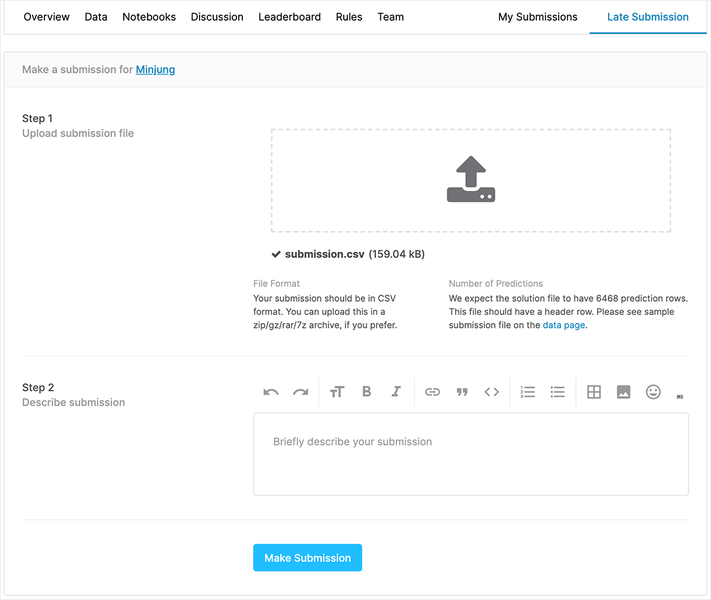

위의 화면에서 Step 1에 점선으로 보이는 제출 박스를 클릭하거나, submission.csv 파일을 해당 박스 안에 드래그앤드롭 하면 파일이 업로드됩니다.

성공적으로 업로드하였다면, Step 2에 원하는 메세지를 작성한 후 Make Submission을 클릭해 주세요!

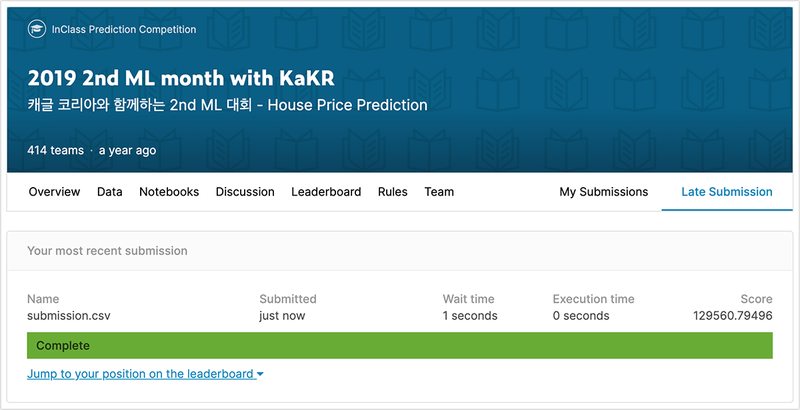

위와 같은 화면이 보인다면 성공입니다. 오른쪽에 129560 정도의 점수도 보이는군요!! 하하 열심히 개선해 봐야겠습니다.

Q. 여러분들이 제출한 점수는 몇 점이 나왔나요?

Private Score : 116130.98270  

Public Score : 120031.23722

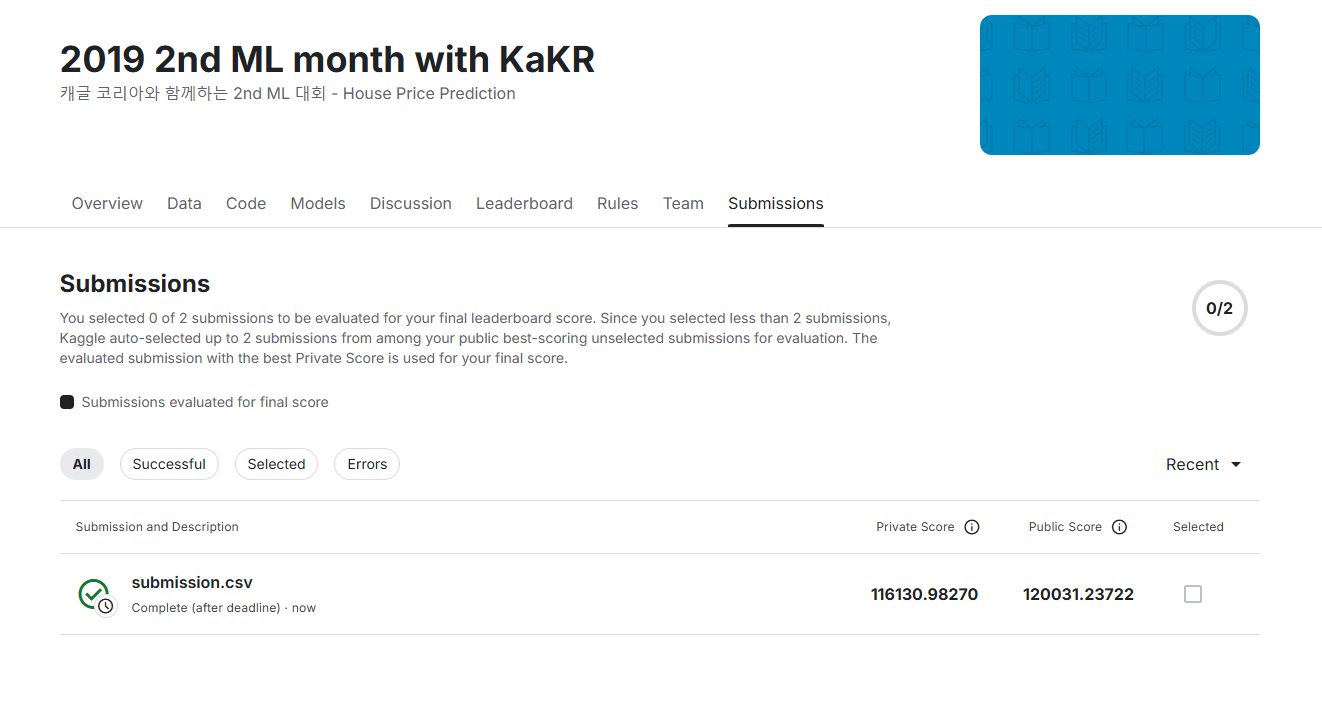


# 10-9. 랭킹을 올리고 싶다면? (1) 다시 한 번, 내 입맛대로 데이터 준비하기


### 최적의 모델을 찾아서, 하이퍼 파라미터 튜닝
---
자, 이제 지난 결과를 개선해 볼 시간입니다.

더 좋은 결과를 얻으려면 어떻게 해야 할까요? 우리는 아직 모델을 하나도 건드려보지 않았습니다.
이번 스텝에서는 직접 다양한 하이퍼 파라미터를 튜닝해보면서 모델의 성능을 끌어올려 볼 것입니다.

Q8. 머신러닝에서 '파라미터' (혹은 모델 파라미터) 와 '하이퍼 파라미터'는 각각 무엇이고, 어떻게 다를까요?  

파라미터는 모델이 데이터로부터 학습하는 값  

하이퍼 파라미터는 최적의 성능을 얻기 위해 사용자가 사전에 설정 하는 값

모델 파라미터는 모델이 학습을 하면서 점차 최적화되는, 그리고 최적화가 되어야 하는 파라미터입니다.
예를 들어 선형 회귀의 경우 y_pred = W*x + b 라는 식으로 예측값을 만들어 낼 텐데, 여기에서 모델 파라미터는 W 입니다. 모델은 학습 과정을 거치면서 최적의 y_pred 값, 즉 y_true에 가장 가까운 값을 출력해낼 수 있는 최적의 W를 찾아나갈 것입니다.
반면, 하이퍼 파라미터는 모델이 학습을 하기 위해서 사전에 사람이 직접 입력해 주는 파라미터입니다.
이는 모델이 학습하는 과정에서 변하지 않습니다. 예를 들어 학습 횟수에 해당하는 epoch 수, 가중치를 업데이트할 학습률(learning rate), 또는 선형 규제를 담당하는 labmda 값 등이 이에 해당합니다.

### 다시 한번, 내 입맛대로 데이터 준비하기
---
Baseline 커널을 열심히 따라 해보았으니, 이제는 우리가 주도적으로 다시 데이터를 다뤄봐야겠죠.  

처음의 마음가짐으로 돌아와서! 다시 데이터를 가져오는 것부터 시작하겠습니다.

In [50]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [51]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


네, 역시 date가 눈에 거슬리는군요. 저 친구를 먼저 전처리를 해주어야겠습니다.

Baseline 커널이 했던 것과 달리, 우리는 int, 즉 정수형 데이터로 처리해보겠습니다. 이렇게 하면 모델이 date도 예측을 위한 특성으로 활용할 수 있겠죠!

In [52]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


좋습니다! date 컬럼은 깔끔하게 정리가 됐군요.

두 번째로 처리해야 할 것은 바로 타겟 데이터에 해당하는 price 컬럼이죠.  
y 변수에 price를 넣어두고, train에서는 삭제하겠습니다.  


In [53]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


마지막으로 id 컬럼을 삭제하는 것까지 하면 기본적인 전처리는 모두 마무리됩니다.

In [54]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


test 데이터에 대해서도 같은 작업을 진행합니다.
단, test에 우리가 맞추어야 할 타겟 데이터인 price는 없으니 훈련 데이터셋과는 다르게 price에 대한 처리는 해주지 않아도 된다는 것을 잊지 마세요!

Q. train 데이터와 마찬가지로 test 데이터도 전처리하는 코드를 작성해 보세요.

In [55]:
# [[YOUR CODE]]
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [56]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


자, 그러면 타겟 데이터인 y를 한번 확인해 보겠습니다.

In [57]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

네, 아주 큰 값들로 이루어져 있군요. 직접 코드를 작성해 가격 데이터의 분포도 한번 확인해 보시죠.

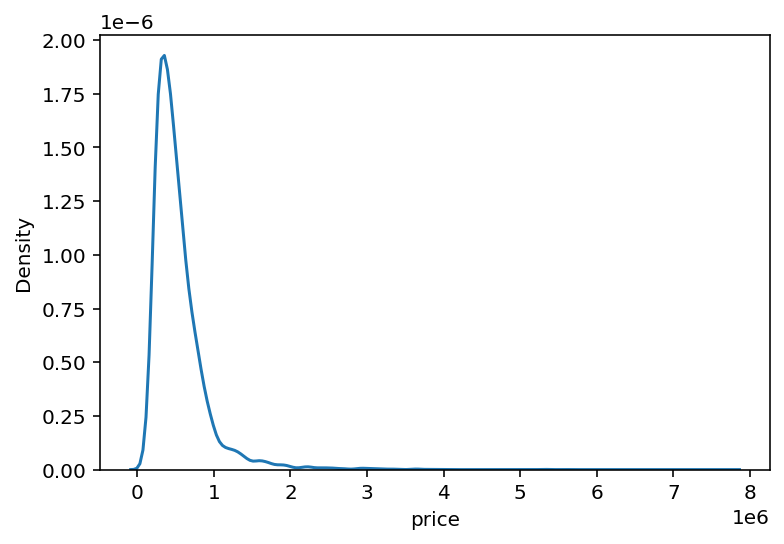

In [58]:
"""
seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인해주세요!
"""

#코드 작성
sns.kdeplot(y)
plt.show()

네, 아까 퀴즈에서도 잠깐 봤던 분포입니다. 앞서 살펴봤듯이 price는 왼쪽으로 크게 치우쳐 있는 형태를 보입니다.

따라서 y는 np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌리겠습니다.  

np.expm1()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 줍니다.

- numpy.log1p
- numpy.expm1

https://numpy.org/doc/stable/reference/generated/numpy.log1p.html

https://numpy.org/doc/stable/reference/generated/numpy.expm1.html

In [59]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

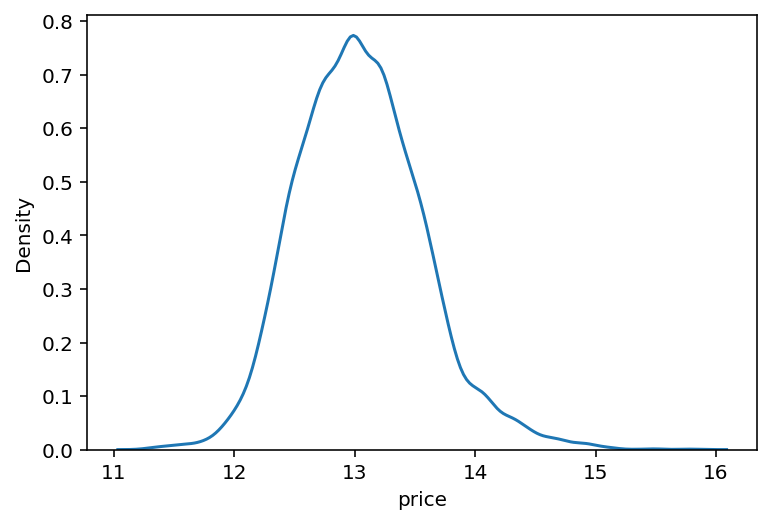

In [60]:
sns.kdeplot(y)
plt.show()

비교적 완만한 정규분포의 형태로 잘 변환되었습니다.

그러면 info() 함수로 전체 데이터의 자료형을 한눈에 확인해 볼까요?

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

모두 실수 또는 정수 자료형으로, 문제 없이 모델 학습에 활용할 수 있을 것 같습니다.

# 10-10. 랭킹을 올리고 싶다면? (2) 다양한 실험을 위해 함수로 만들어 쓰자

이제부터 본격적으로 모델 튜닝을 해보겠습니다.

머신러닝 모델을 학습시키고 튜닝을 하다 보면 몇 시간이 훌쩍 지났는지 모를 만큼 실험해볼 것들이 많습니다.
보다 다양하고 많은 실험을 하기 위해서는, 그만큼 실험을 위한 도구들이 잘 준비되어 있는 것이 유리하겠죠.

따라서 여러 가지 반복되는 작업들은 함수로 먼저 만들어 놓고 많은 실험을 하는 것이 좋습니다. 이제부터 구현해 보겠습니다.

RMSE 계산
먼저 필요한 라이브러리를 가져오겠습니다.
데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 train_test_split 함수와, RMSE 점수를 계산하기 위한 mean_squared_error를 가져옵니다.

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 만들어놓겠습니다.  

한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점입니다.  

exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있겠죠!  

In [64]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


다음으로 XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델을 가져오겠습니다.

In [65]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


아래와 같이 모델 인스턴스를 생성한 후 models라는 리스트에 넣어줍니다.

이때, 모델 파라미터 초기화나 데이터셋 구성에 사용되는 랜덤 시드값인 random_state 값을 특정 값으로 고정시키거나, 아니면 지정하지 않고 None으로 세팅할 수 있습니다. random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현됩니다. 하지만 이 값을 지정하지 않고 None으로 남겨 두면 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라집니다.

앞으로 우리는 베이스라인에서부터 시작해서 다양한 실험을 통해 성능이 개선되는지를 검증해 보려고 합니다. 이때, 어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해서는 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 합니다. 따라서 아래와 같이 random_state 값을 특정 값으로 고정시킬 것입니다. 혹시 고정하지 않았을 때 어떤 상황이 벌어지는지 궁금하시다면 random_state 값을 None으로 남겨두고 실험을 반복해 보셔도 됩니다.

In [66]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


각 모델의 이름은 다음과 같이 클래스의 __name__ 속성에 접근해서 얻을 수 있습니다.

In [67]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [68]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    # [[YOUR CODE]]
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)
    
    # 모델 학습
    # [[YOUR CODE]]
    model.fit(X_train, y_train)
    
    # 예측
    # [[YOUR CODE]]
    y_pred = model.predict(X_test)
    
    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred) # [[YOUR CODE]]

# data frame에 저장
score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

네, 이렇게 간단하게 네 가지의 모델에 대해 모두 RMSE값을 빠르게 얻을 수 있습니다.

위의 과정을 get_scores(models, train, y) 함수로 만들어 보겠습니다. 아래에 있는 코드 블록에 작성 후 실행해 보세요.

In [69]:
score_df

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [70]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        # [[YOUR CODE]]
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=random_state)

        # 모델 학습
        # [[YOUR CODE]]
        model.fit(X_train, y_train)

        # 예측
        # [[YOUR CODE]]
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred) # [[YOUR CODE]]

    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


## 10-11. 랭킹을 올리고 싶다면? (3) 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

이제 모델과 데이터셋이 있다면 RMSE 결괏값을 나타내주는 함수가 준비되었으니, 다양한 하이퍼 파라미터로 실험하는 일만 남았죠.

실험은 sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용합니다.
다음 함수를 import 해주세요!

In [71]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


GridSearchCV란 무엇일까요?

우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있습니다. 두 가지 모두 하이퍼 파라미터를 조합해 보는 방법입니다.

그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하겠네요!

랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.

그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있는 반면, 랜덤 탐색에서는 말 그대로 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있습니다. 하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없어요.

다음 이미지가 그리드 탐색(grid search)과 랜덤 탐색(random search) 두 가지를 잘 나타내고 있습니다.
그리드 탐색은 정해진 하이퍼 파라미터의 조합을 격자와 같이 탐색하는 반면, 랜덤 탐색은 랜덤으로 점을 찍어서 탐색합니다.

확실히 그리드 탐색의 탐색 공간은 매우 제한적인 반면 랜덤 탐색은 탐색하는 공간이 훨씬 넓습니다.



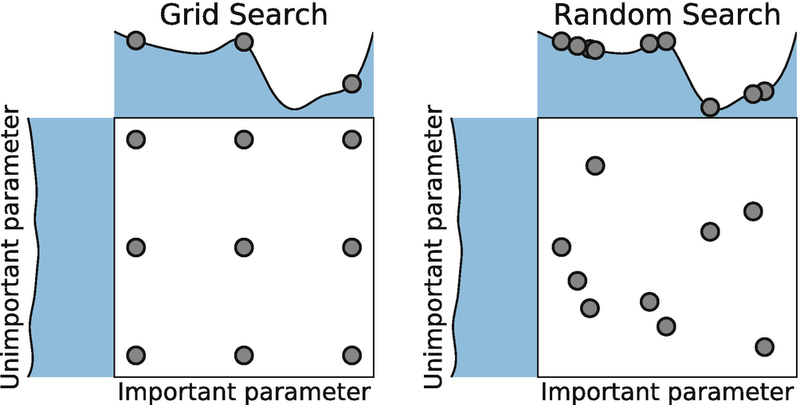

우리는 앞서 언급했듯 다양한 파라미터를 입력하면 가능한 모든 조합을 탐색하는 사이킷런의 GridSearchCV를 활용해 볼 것입니다.

먼저 GridSearchCV에 입력되는 인자들은 다음과 같습니다.

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수  

그러면 param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비하겠습니다.

In [73]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

그다음으로 모델을 준비합니다. 모델은 LightGBM(lgbm)를 사용해봅시다.

In [74]:
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


그러면 model, param_grid와 함께 다른 여러 가지 인자를 넣어서 GridSearchCV를 수행할 수 있습니다!

다음과 같이 GridSearchCV를 이용해서 grid_model 모델을 초기화하고, train과 y 데이터로 모델을 간단히 학습시키면 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

In [75]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

Q. 위에 출력된 메세지에 나타난 'totalling 20 fits' 에서 20은 어떻게 계산된 값일까요?

위에서 우리가 입력한 param_grid에 n_estimators 두 가지, max_depth 두 가지를 넣었으므로 가능한 조합은 총 2 × 2 = 4가지입니다.
또한, cross validation은 각 경우마다 5번을 진행하니 총 20 fits를 진행하게 됩니다.
여기에서 cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다. 간단하게, 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확하겠죠!

자, grid_model.fit 함수를 통해서 4가지 조합에 대한 실험을 모두 마쳤습니다.

실험에 대한 결과는 다음과 같이 grid_model.cv_results_ 안에 저장됩니다.

In [76]:
grid_model.cv_results_

{'mean_fit_time': array([0.60572801, 0.63388009, 1.44935722, 2.2313261 ]),
 'std_fit_time': array([0.22478465, 0.09851415, 0.3503359 , 0.08641237]),
 'mean_score_time': array([0.02865562, 0.05410008, 0.08563809, 0.16112008]),
 'std_score_time': array([0.01494957, 0.01484816, 0.01726911, 0.01335112]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

휴, 정보가 너무 많아서 눈에 잘 들어오지 않는군요. 우리는 원하는 값만 정제해서 확인하도록 하겠습니다.

우리가 관심 있는 정보는 어떤 파라미터 조합일 때 점수가 어떻게 나오게 되는지에 관한 것이겠죠.
파라미터 조합은 위 딕셔너리 중 params에, 각각에 대한 테스트 점수는 mean_test_score에 저장되어 있습니다.

이 두 정보만 빼내어 보겠습니다.

In [77]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [78]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

params에는 각 파라미터의 조합이, score에는 각 조합에 대한 점수가 들어가 있군요.

이제 이 둘만 가지고 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아봅시다.

다음과 같은 형태의 데이터 프레임을 출력하는 코드를 작성해 보세요.

In [79]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


자, 그런데 여기에서 한 가지 의문이 드는 것이 있습니다. 왜 점수는 음수일까요?!

그 이유는 바로 GridSearchCV을 초기화 한 코드에 힌트가 있습니다.
우리가 위에서 GridSearchCV로 grid_model 모델을 초기화할 때, scoring 인자에 무엇을 넣었는지 기억하시나요?

Q. GridSearchCV 에서 모델을 초기화할 때 scoring 인자에는 무엇을 넣었나요?
MSE에 음수를 취한 값인 neg_mean_squared_error를 입력했다.

GridSearchCV를 사용할 때에는 이 외에도 다양한 점수 체계(scoring)를 사용할 수 있습니다. 그에 대한 정보는 다음 페이지에서 확인하겠습니다.

사이킷런 - The scoring parameter: defining model evaluation rules
    - https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter  
    
Q. 위의 페이지에서는 각 점수(scoring)를 세 가지로 분류해놓고 있다. 세 분류 범주는 무엇인가?
 
Classification, Clustering, Regression

네, 우리는 Regression 문제를 풀고 있기 때문에 그에 알맞은 성능 평가 지표를 사용하였습니다.  
neg_mean_squared_error를 사용했기 때문에 점수가 음수로 표현되는 것이죠!  

아래와 같은 간단한 변환 함수로 RMSE 점수를 볼 수 있도록 하겠습니다.  
음수로 된 MSE였으니, -1을 곱해주고 np.sqrt로 루트 연산을 해주면 되겠죠.

In [81]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


앗, 하지만 아직도 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것 같습니다.

그 이유는 price에 있습니다. 위에서 우리는 price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했었죠.
그 후 RMSE 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했습니다.

하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한 것이죠.
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 입니다.
log를 취한 값에서 RMSE를 구했다는 뜻이죠!

이에 맞게 컬럼의 이름을 RMSLE로 변환해 주도록 하겠습니다. 판다스에서 컬럼의 이름 변환은 rename으로 할 수 있습니다.

In [82]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


이제 마지막 할 일은 RMSLE가 낮은 순서대로 정렬하는 것뿐이군요! sort_values로 간단히 할 수 있습니다. 공식 문서를 참고해 직접 작성해 보세요.

pandas.DataFrame.sort_values
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html





In [83]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [86]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

## 10-12. 랭킹을 올리고 싶다면? (4) 제출하는 것도, 빠르고 깔끔하게!

이제 실험에 대한 준비는 모두 끝났습니다! 실험을 통해 좋은 결과를 내는 모델을 찾았다면 제출을 해봐야겠죠.  

제출 과정 또한 하나의 함수로 깔끔하게 진행하겠습니다.

먼저 위에서 만들어놓은 my_GridSearch() 함수로 간단한 그리드 탐색을 해보겠습니다.

In [87]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


가장 좋은 조합은 max_depth=10, n_estimators=100 이군요.
해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출해보겠습니다.

먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성합니다.

가장 좋은 조합은 max_depth=10, n_estimators=100 이군요.
해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출해보겠습니다.

먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성합니다.

In [88]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

앗, 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌리는 것도 잊으면 안 되겠죠!

Q. 앞에서 로그 변환을 했던 것을 다시 원래 스케일로 되돌리는 코드를 작성하세요.

In [89]:
prediction = np.expm1(prediction) # [[YOUR CODE]]
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

이제 위에서 했던 대로 sample_submission.csv 파일을 가져와보겠습니다.

In [90]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [91]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


위의 데이터를 csv 파일로 저장하겠습니다.

단, 앞으로는 많은 실험이 있을 예정이니 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리될 것입니다!

In [93]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [94]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [95]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv saved!
